# 0. Imports

## 0.1. Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
from sklearn import metrics as m
from plotly import express as px
import umap.umap_ as umap
from IPython.display import HTML
from pandas_profiling import ProfileReport

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
viridis0 = sns.color_palette(sns.color_palette('viridis', 5)[0], as_cmap=True)
viridis1 = sns.color_palette(sns.color_palette('viridis', 5)[2], as_cmap=True)
viridis2 = sns.color_palette(sns.color_palette('viridis', 5)[4], as_cmap=True)
simple_viridis = sns.set_palette([viridis0,viridis1,viridis2])

## 0.2. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Dataset

In [5]:
df = pd.read_csv('../data/CC GENERAL.csv')

In [6]:
df.sample().T

4392
CUST_ID                               C14515
BALANCE                           497.919885
BALANCE_FREQUENCY                        1.0
PURCHASES                            1186.09
ONEOFF_PURCHASES                       397.0
INSTALLMENTS_PURCHASES                789.09
CASH_ADVANCE                      513.979897
PURCHASES_FREQUENCY                 0.916667
ONEOFF_PURCHASES_FREQUENCY          0.166667
PURCHASES_INSTALLMENTS_FREQUENCY    0.833333
CASH_ADVANCE_FREQUENCY              0.333333
CASH_ADVANCE_TRX                           8
PURCHASES_TRX                             30
CREDIT_LIMIT                           500.0
PAYMENTS                          1487.08197
MINIMUM_PAYMENTS                  769.568121
PRC_FULL_PAYMENT                         0.0
TENURE                                    12

# 1. Data Description

In [7]:
df1 = df.copy()

## 1.1. Rename Columns

In [8]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [10]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5. Replace NA

In [12]:
# Replacing credit_limit variable
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

# Replacing minimum_payments variable
df1['minimum_payments'].fillna(0,inplace=True)

## 1.6. Change dtypes

In [13]:
df1['cust_id'] = df1['cust_id'].map(lambda x: x[1:]).astype(int)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [15]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
metrics

Attributes   Min          Max        Range         Mean       Median          Std       Skew    Kurtosis
0                            balance   0.0  19043.13856  19043.13856  1564.474828   873.385231  2081.415590   2.393386    7.674751
1                  balance_frequency   0.0      1.00000      1.00000     0.877271     1.000000     0.236891  -2.023266    3.092370
2                          purchases   0.0  49039.57000  49039.57000  1003.204834   361.280000  2136.515413   8.144269  111.388771
3                   oneoff_purchases   0.0  40761.25000  40761.25000   592.437371    38.000000  1659.795184  10.045083  164.187572
4             installments_purchases   0.0  22500.00000  22500.00000   411.067645    89.000000   904.287592   7.299120   96.575178
5                       cash_advance   0.0  47137.21176  47137.21176   978.871112     0.000000  2097.046713   5.166609   52.899434
6                purchases_frequency   0.0      1.00000      1.00000     0.490351     0.500000     0.401348   0.060164   -1.638631
7         oneoff_purchases_frequency   0.0      1.00000      1.00000     0.202458     0.083333     0.298319   1.535613    1.161846
8   purchases_installments_frequency   0.0      1.00000      1.00000     0.364437     0.166667     0.397426   0.509201   -1.398632
9             cash_advance_frequency   0.0      1.50000      1.50000     0.135144     0.000000     0.200110   1.828686    3.334734
10                  cash_advance_trx   0.0    123.00000    123.00000     3.248827     0.000000     6.824265   5.721298   61.646862
11                     purchases_trx   0.0    358.00000    358.00000    14.709832     7.000000    24.856260   4.630655   34.793100
12                      credit_limit  50.0  30000.00000  29950.00000  4493.952864  3000.000000  3638.712384   1.522374    2.836442
13                          payments   0.0  50721.48336  50721.48336  1733.143852   856.901546  2894.902017   5.907620   54.770736
14                  minimum_payments   0.0  76406.20752  76406.20752   833.983453   289.628402  2335.859412  13.808430  292.357730
15                  prc_full_payment   0.0      1.00000      1.00000     0.153715     0.000000     0.292483   1.942820    2.432395
16                            tenure   6.0     12.00000      6.00000    11.517318    12.000000     1.338256  -2.943017    7.694823

# 2. Feature Filtering

In [16]:
df2 = df1.copy()

In [173]:
# Filtering three lines that put number of transactions equal to 0 and transaction value different from 0;
df2 = df2[~((df1['purchases_trx']==0) & (df1['purchases']!=0))]

# Filtering the single line where purchases and cash_advance are zero;
df2 = df2[~((df4['purchases']==0) & (df2['cash_advance']==0))]

# Filtering the eight lines where cash_advance_frequency is greater than 1;
df2 = df2[~(df2['cash_advance_frequency']>1)]

# Filtering the 18 lines where purchases variable doesn't match the sum of oneoff_purchases and installments_purchases
df2 = df2[~(abs(df2['purchases'] - (df2['oneoff_purchases'] + df2['installments_purchases'])) > 1)]

# 3. Feature Engineering

In [183]:
df3 = df2.copy()

## 3.1. Feature Creation

In [88]:
df3.sample(5).T

5355          4740          62            2272          3627
cust_id                           15507.000000  14870.000000  10064.000000  12343.000000  13730.000000
balance                             868.331112   1845.210833    809.582978    137.909416    107.536958
balance_frequency                     1.000000      1.000000      0.909091      1.000000      1.000000
purchases                          1167.150000      0.000000      0.000000    897.420000    555.000000
oneoff_purchases                    864.280000      0.000000      0.000000    684.120000      0.000000
installments_purchases              302.870000      0.000000      0.000000    213.300000    555.000000
cash_advance                        748.152104   1960.264859   3819.672466      0.000000      0.000000
purchases_frequency                   1.000000      0.000000      0.000000      0.916667      1.000000
oneoff_purchases_frequency            0.250000      0.000000      0.000000      0.916667      0.000000
purchases_installments_frequency      1.000000      0.000000      0.000000      0.583333      0.833333
cash_advance_frequency                0.250000      0.250000      0.545455      0.000000      0.000000
cash_advance_trx                      4.000000      3.000000      7.000000      0.000000      0.000000
purchases_trx                        26.000000      0.000000      0.000000     27.000000      6.000000
credit_limit                       3000.000000   4500.000000   4150.000000   7000.000000   1000.000000
payments                            704.323375    331.387568   4372.148648    965.182597    313.879828
minimum_payments                    240.060933    600.297574    241.645387    191.931603     48.966970
prc_full_payment                      0.083333      0.000000      0.090909      0.083333      0.000000
tenure                               12.000000     12.000000     11.000000     12.000000      6.000000

In [215]:
df_ref = df3[['cust_id',
              'oneoff_purchases',
              'installments_purchases',
              'cash_advance',
              'oneoff_purchases_frequency',
              'purchases_installments_frequency',
              'cash_advance_frequency',
              'purchases_trx',
              'cash_advance_trx']].copy()

df_ref.sample(5).T

4982          6525          5398          5508          8211
cust_id                           15123.000000  16704.000000  15551.000000  15662.000000  18431.000000
oneoff_purchases                      0.000000      0.000000      0.000000      0.000000      0.000000
installments_purchases              790.800000      0.000000      0.000000      0.000000      0.000000
cash_advance                       5001.962631    724.694411    566.943998    211.854586   1117.228257
oneoff_purchases_frequency            0.000000      0.000000      0.000000      0.000000      0.000000
purchases_installments_frequency      1.000000      0.000000      0.000000      0.000000      0.000000
cash_advance_frequency                0.333333      0.250000      0.250000      0.181818      0.166667
purchases_trx                        17.000000      0.000000      0.000000      0.000000      0.000000
cash_advance_trx                      4.000000      5.000000     10.000000      2.000000      5.000000

# 4. EDA (Exploratory Data Analysis)

In [184]:
df4 = df3.copy()

## 4.1. Univariate Analysis

**Notes:**
1. Clusters should be Cohesive (closely united) and Separate (away one from another)
2. Metrics:
    - Min, Max, Range (Dispersion);
    - Mean and Median;
    - Standard Deviation and Variation;
    - Coefficient of Variation (CV);
    - Distribution;

In [148]:
#profile = ProfileReport(df4)
#profile.to_file('../eda/univariate_analysis.html')

<AxesSubplot:>

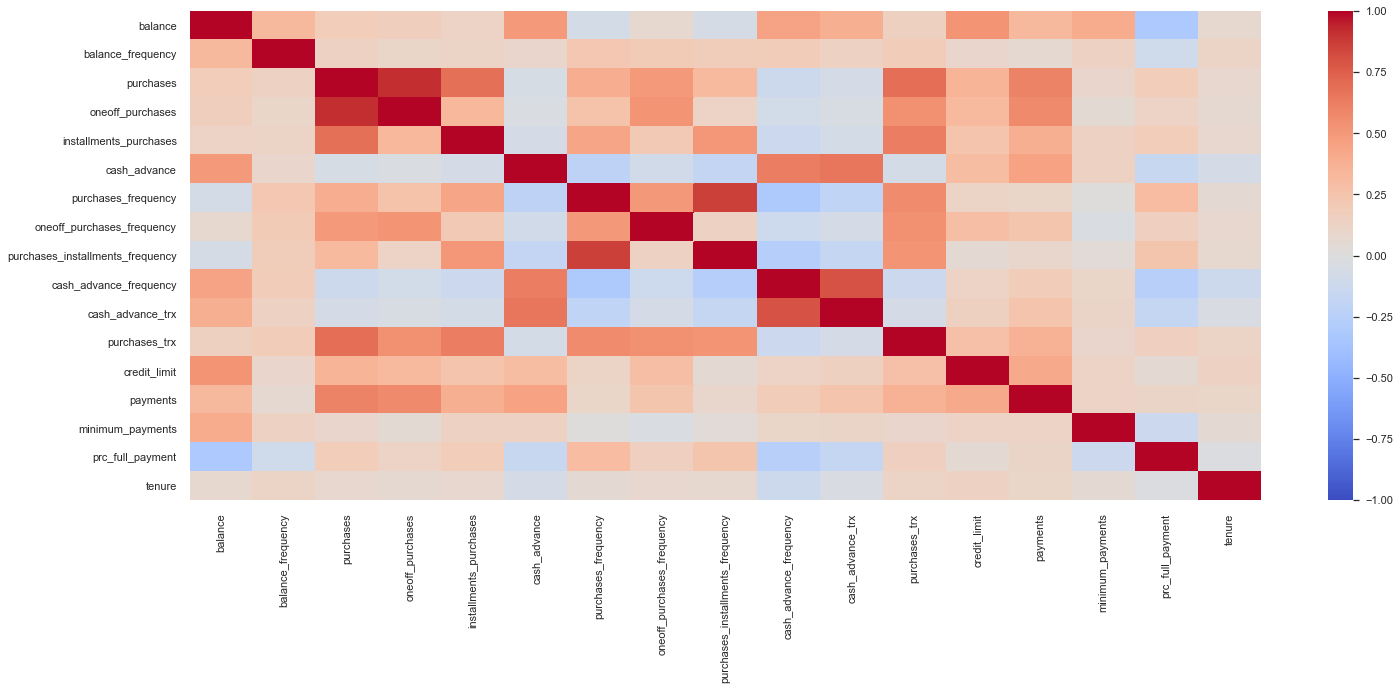

In [149]:
sns.heatmap(df4.drop('cust_id',axis=1).corr(),cmap='coolwarm',vmin=-1,vmax=1)

### 4.1.1. balance

In [150]:
df4[df4['balance']==0].head()

cust_id  balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit    payments  minimum_payments  prc_full_payment  tenure
99      10104      0.0                0.0       0.00               0.0                    0.00     89.849004             0.000000                         0.0                          0.000000                0.142857                 1              0        3000.0  138.021428               0.0               0.0       7
181     10187      0.0                0.0      23.00               0.0                   23.00      0.000000             0.083333                         0.0                          0.083333                0.000000                 0              1        5000.0    0.000000               0.0               0.0      12
654     10680      0.0                0.0       0.00               0.0                    0.00    310.888779             0.000000                         0.0                          0.000000                0.083333                 1              0        9000.0    0.000000               0.0               0.0      12
860     10891      0.0                0.0     199.88               0.0                  199.88      0.000000             0.750000                         0.0                          0.750000                0.000000                 0             14        4000.0    0.000000               0.0               0.0      12
1131    11171      0.0                0.0      12.65               0.0                   12.65      0.000000             0.083333                         0.0                          0.083333                0.000000                 0              1        5000.0    0.000000               0.0               0.0      12

In [151]:
# Whenever the variable balance is equal to 0, the variable balance_frequency will also be equal to zero.
# This makes perfect sense when we take into account the relationship and meaning of these two variables.
df4[df4['balance']==0]['balance_frequency'].value_counts(normalize=True)

0.0    1.0
Name: balance_frequency, dtype: float64

In [152]:
print('{} clients have a balance greater than their credit limit.'.format(df4[df4['balance']>df4['credit_limit']].shape[0]))

227 clients have a balance greater than their credit limit.


In [153]:
df4['diff'] = df4['balance'] - df4['credit_limit']

df4[df4['diff'].isin(df4['diff'].sort_values(ascending=False)[:5].values.tolist())]

cust_id       balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit      payments  minimum_payments  prc_full_payment  tenure         diff
138     10144  19043.138560                1.0   22009.92           9449.07                12560.85         0.000                 1.00                    0.750000                          1.000000                0.000000                 0            216       18000.0  23018.575830       18621.01331               0.0      12  1043.138560
567     10591   3457.086184                1.0    2448.60              0.00                 2448.60         0.000                 1.00                    0.000000                          1.000000                0.000000                 0             12        1700.0    227.514473       38512.12477               0.0      12  1757.086184
1012    11047  12373.333480                1.0     830.15            200.00                  630.15     10249.921                 0.75                    0.166667                          0.583333                0.916667                26             14       11000.0  14040.866350       12245.92601               0.0      12  1373.333480
4086    14202   6832.111113                1.0    6508.08              0.00                 6508.08         0.000                 1.00                    0.000000                          1.000000                0.000000                 0             72        6000.0   8210.115891       13621.70839               0.0      12   832.111113
4376    14499  10571.411070                1.0    7739.48              0.00                 7739.48         0.000                 1.00                    0.000000                          1.000000                0.000000                 0             44        8000.0   2688.447014       76406.20752               0.0      12  2571.411070

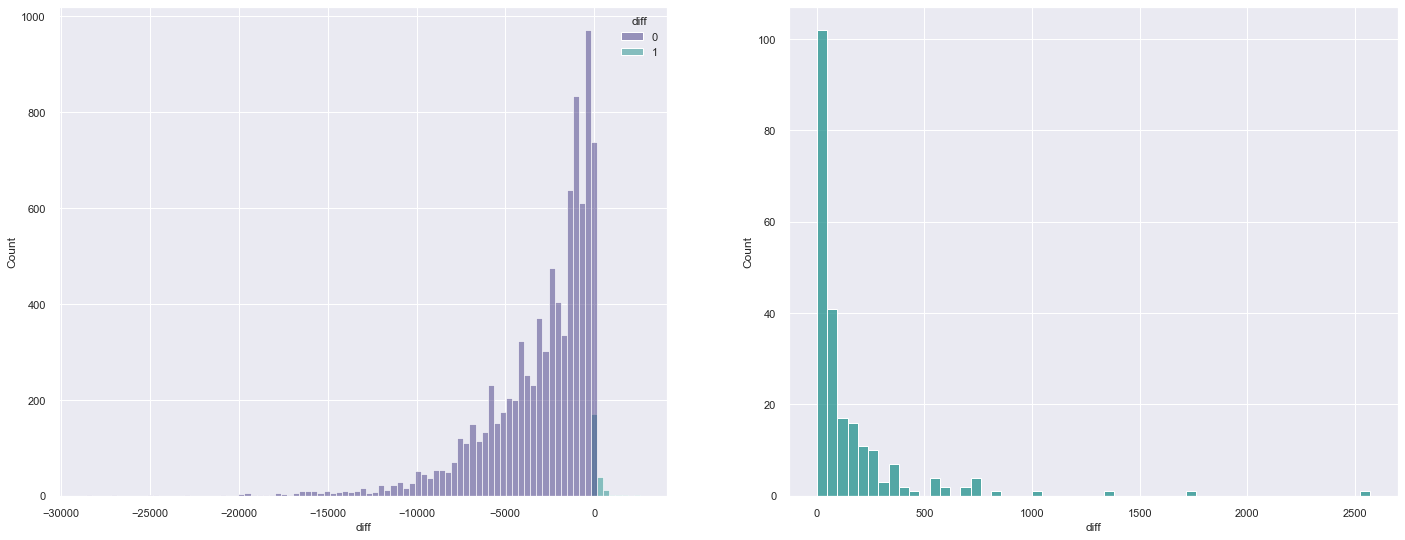

In [154]:
# Histplot of cases that have balance over credit_limit
plt.subplot(1,2,1)
sns.histplot(x=df4['diff'],hue=df4['diff'].map(lambda x: 1 if x>0 else 0),palette = sns.set_palette([viridis0,viridis1]));

plt.subplot(1,2,2)
sns.histplot(df4[df4['diff']>0]['diff'],color=viridis1);

In [155]:
df4.drop('diff',axis=1,inplace=True)

### 4.1.2. balance_frequency

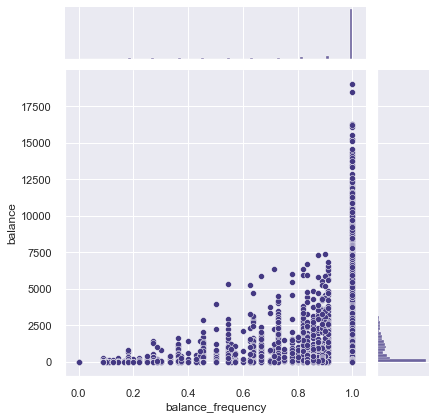

In [156]:
# Most of customers (69.4%) have the maximum value of balance_frequency (1), among these cases, there are all customers with high balance (greater than 8000)
sns.jointplot(data=df4,x='balance_frequency',y='balance',kind='scatter',color=viridis0);

### 4.1.3. purchases

### 4.1.4. oneoff_purchases & installments_purchases

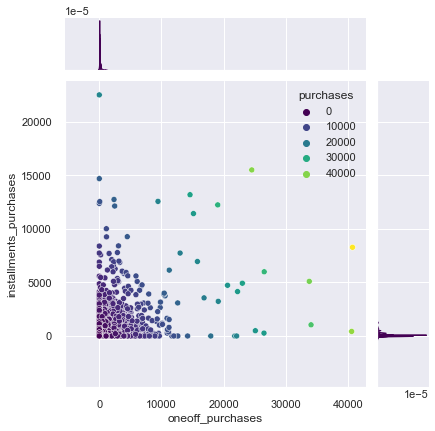

In [214]:
# Proof of the strong correlation between Purchases, OneOffPurchases and InstallmentsPurchases
sns.jointplot(data=df4,x='oneoff_purchases',y='installments_purchases',hue='purchases',palette='viridis');

### 4.1.5. purchases_frequency

In [174]:
one_and_zero = round(df4['purchases_frequency'].value_counts(normalize=True).loc[0]*100 + df4['purchases_frequency'].value_counts(normalize=True).loc[1]*100,2)
print(f'Consumers with purchases_frequency equal to 0 or 1 occupy {one_and_zero}% of the entire database.')

Consumers with purchases_frequency equal to 0 or 1 occupy 47.18% of the entire database.


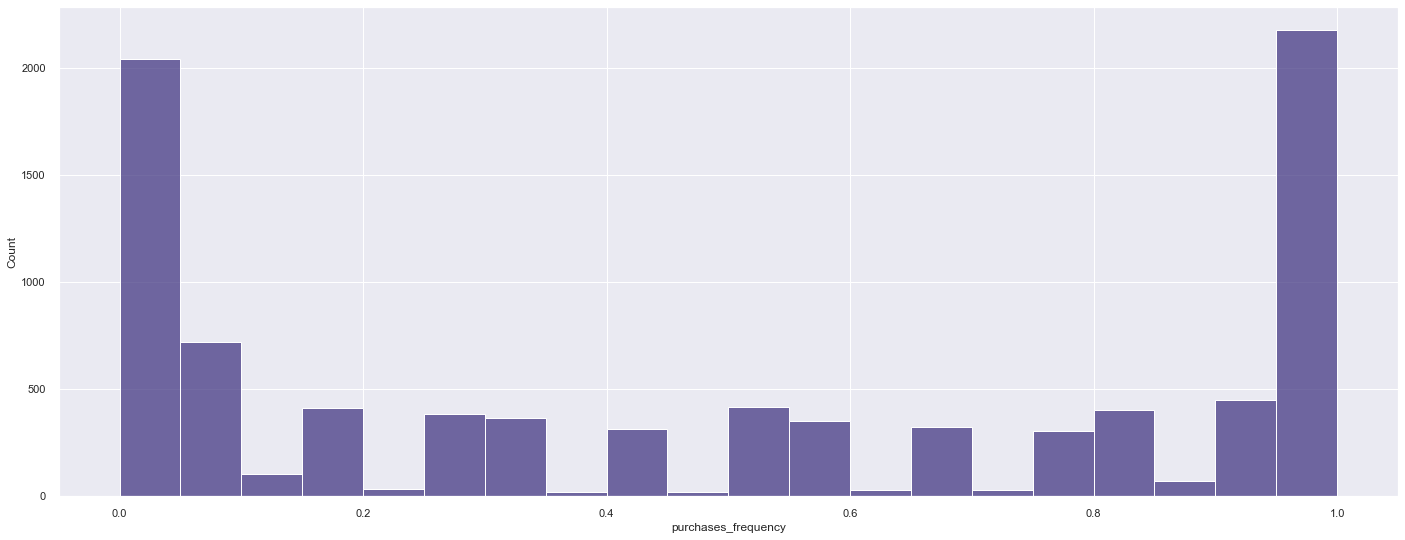

In [175]:
# The histogram below demonstrates the statement made above
sns.histplot(df4['purchases_frequency'],bins=20);

### 4.1.6. oneoff_purchases_frequency & purchases_installments_frequency

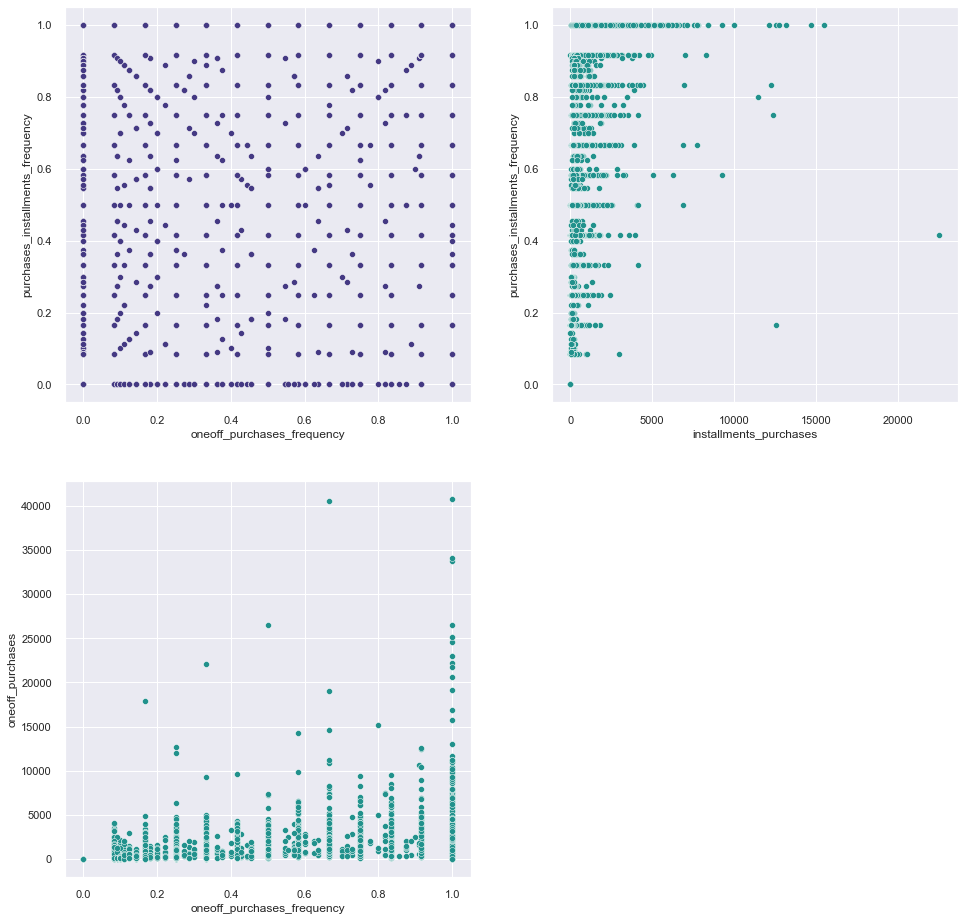

In [176]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
sns.scatterplot(data=df4,y='purchases_installments_frequency',x='oneoff_purchases_frequency',color=viridis0);

plt.subplot(2,2,2)
sns.scatterplot(data=df4,y='purchases_installments_frequency',x='installments_purchases',color=viridis1);

plt.subplot(2,2,3)
sns.scatterplot(data=df4,y='oneoff_purchases',x='oneoff_purchases_frequency',color=viridis1);

### 4.1.7. cash_advance, cash_advance_frequency, cash_advance_trx

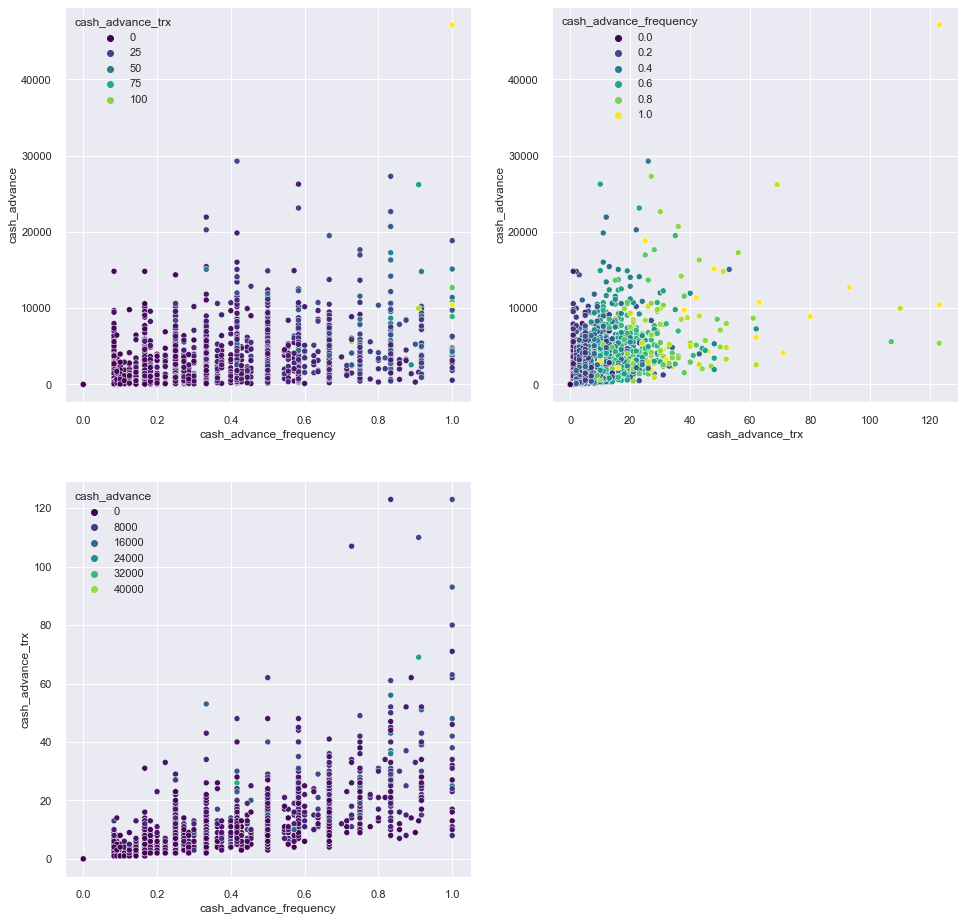

In [177]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
sns.scatterplot(data=df4,x='cash_advance_frequency',y='cash_advance',hue='cash_advance_trx',palette='viridis');

plt.subplot(2,2,2)
sns.scatterplot(data=df4,x='cash_advance_trx',y='cash_advance',hue='cash_advance_frequency',palette='viridis');

plt.subplot(2,2,3)
sns.scatterplot(data=df4,x='cash_advance_frequency',y='cash_advance_trx',hue='cash_advance',palette='viridis');

### 4.1.8. purchases_trx

In [185]:
# The max value of: purchases
#                   oneoff_purchases
#                   isntallments_purchases
#                   purchases_frequency
#                   one_off_purchases_frequency
#                   purchases_installments_frequency
# is 0 when purchases_trx is 0
df4.groupby('purchases_trx').max().loc[0]

cust_id                             19189.00000
balance                             14581.45914
balance_frequency                       1.00000
purchases                               0.00000
oneoff_purchases                        0.00000
installments_purchases                  0.00000
cash_advance                        26194.04954
purchases_frequency                     0.00000
oneoff_purchases_frequency              0.00000
purchases_installments_frequency        0.00000
cash_advance_frequency                  1.00000
cash_advance_trx                      123.00000
credit_limit                        19000.00000
payments                            34107.07499
minimum_payments                    61031.61860
prc_full_payment                        1.00000
tenure                                 12.00000
Name: 0, dtype: float64

### 4.1.11. credit_limit

<AxesSubplot:xlabel='payments', ylabel='credit_limit'>

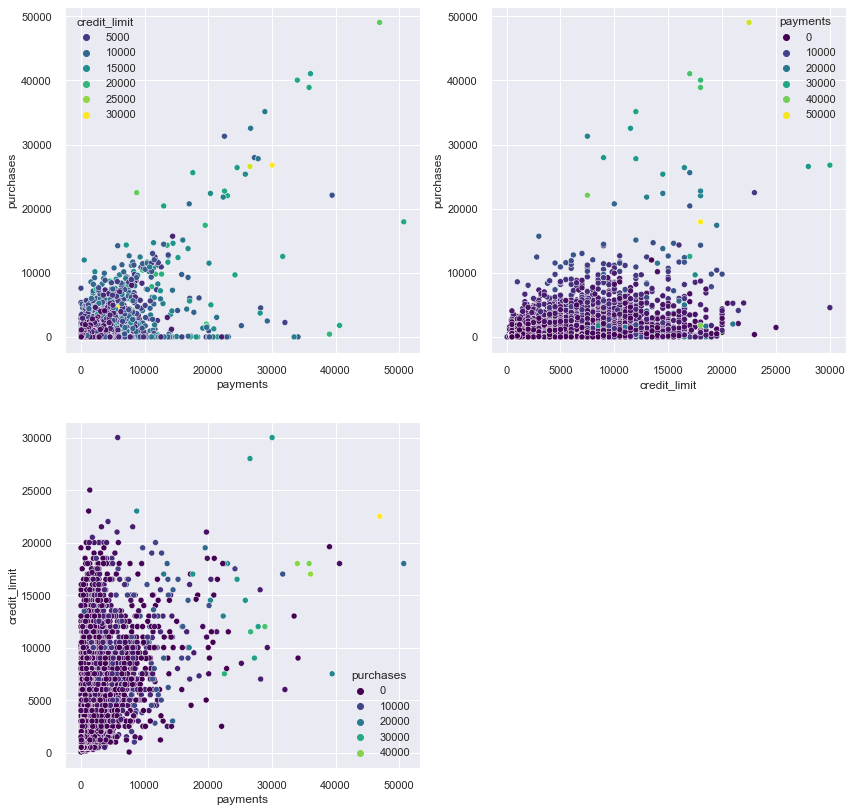

In [198]:
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
sns.scatterplot(data=df4,y='purchases',x='payments',hue='credit_limit',palette='viridis')

plt.subplot(2,2,2)
sns.scatterplot(data=df4,x='credit_limit',y='purchases',hue='payments',palette='viridis')

plt.subplot(2,2,3)
sns.scatterplot(data=df4,y='credit_limit',x='payments',hue='purchases',palette='viridis')

### 4.1.12. payments

In [211]:
pass

### 4.1.13. minimum_payments

In [210]:
pass

### 4.1.14. prc_full_payment

In [209]:
pass

### 4.1.15. tenure

In [206]:
pass

# 5. Data Preparation

In [237]:
df5 = df_ref.copy()

In [238]:
df5.head()

cust_id  oneoff_purchases  installments_purchases  cash_advance  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  purchases_trx  cash_advance_trx
0    10001              0.00                    95.4      0.000000                    0.000000                          0.083333                0.000000              2                 0
1    10002              0.00                     0.0   6442.945483                    0.000000                          0.000000                0.250000              0                 4
2    10003            773.17                     0.0      0.000000                    1.000000                          0.000000                0.000000             12                 0
3    10004           1499.00                     0.0    205.788017                    0.083333                          0.000000                0.083333              1                 1
4    10005             16.00                     0.0      0.000000                    0.083333                          0.000000                0.000000              1                 0

In [49]:
## Standard Scaler
ss = pp.StandardScaler()

df5['oneoff_purchases_frequency'] = ss.fit_transform(df5[['oneoff_purchases_frequency']])
df5['oneoff_purchases'] = ss.fit_transform(df5[['oneoff_purchases']])
df5['installments_purchases'] = ss.fit_transform(df5[['installments_purchases']])
df5['purchases_trx'] = ss.fit_transform(df5[['purchases_trx']])
df5['purchases_installments_frequency'] = ss.fit_transform(df5[['purchases_installments_frequency']])

In [278]:
ss = pp.StandardScaler()
pd.DataFrame(ss.fit_transform([sinned])).hist()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001C1C9DD1B80> (for post_execute):


KeyboardInterrupt: 

In [272]:
def processing_skewed_data(x):
    if x.min()==0:
        second_min = sort(x.unique())[1]
        x = x + second_min
    
    return 0
sinned = no_zero.apply(lambda x: 1/x)
no_zero = df5['oneoff_purchases_frequency'].apply(lambda x: x+0.0416665 if x==0 else x)


# 6. Feature Selection

In [50]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [51]:
X = df6.drop('cust_id',axis=1)

In [52]:
clusters = [2,3,4,5,6,7,8,9]

In [53]:
model = KMeans(random_state=101)

## 7.1. Within-Cluster Sum of Square (WSS)

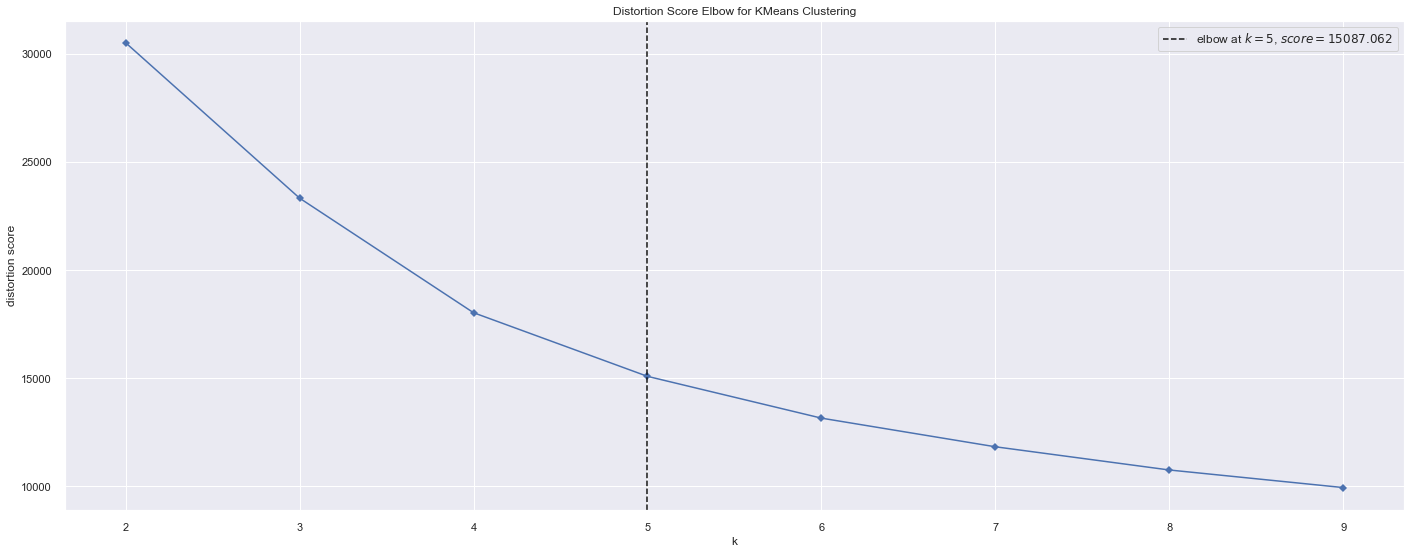

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
kmeans = KElbowVisualizer(model,k=clusters, metric='distortion',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

## 7.2. Sillhouette Score

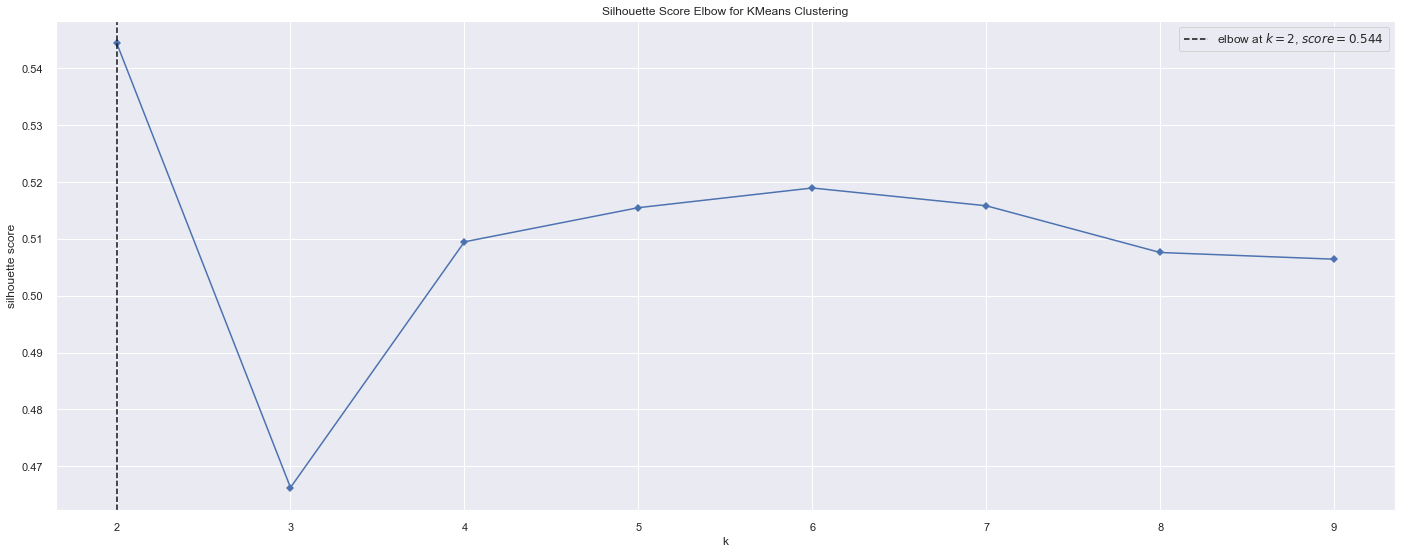

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [55]:
kmeans = KElbowVisualizer(model,k=clusters, metric='silhouette',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

### 7.2.1. Silhouette Analysis

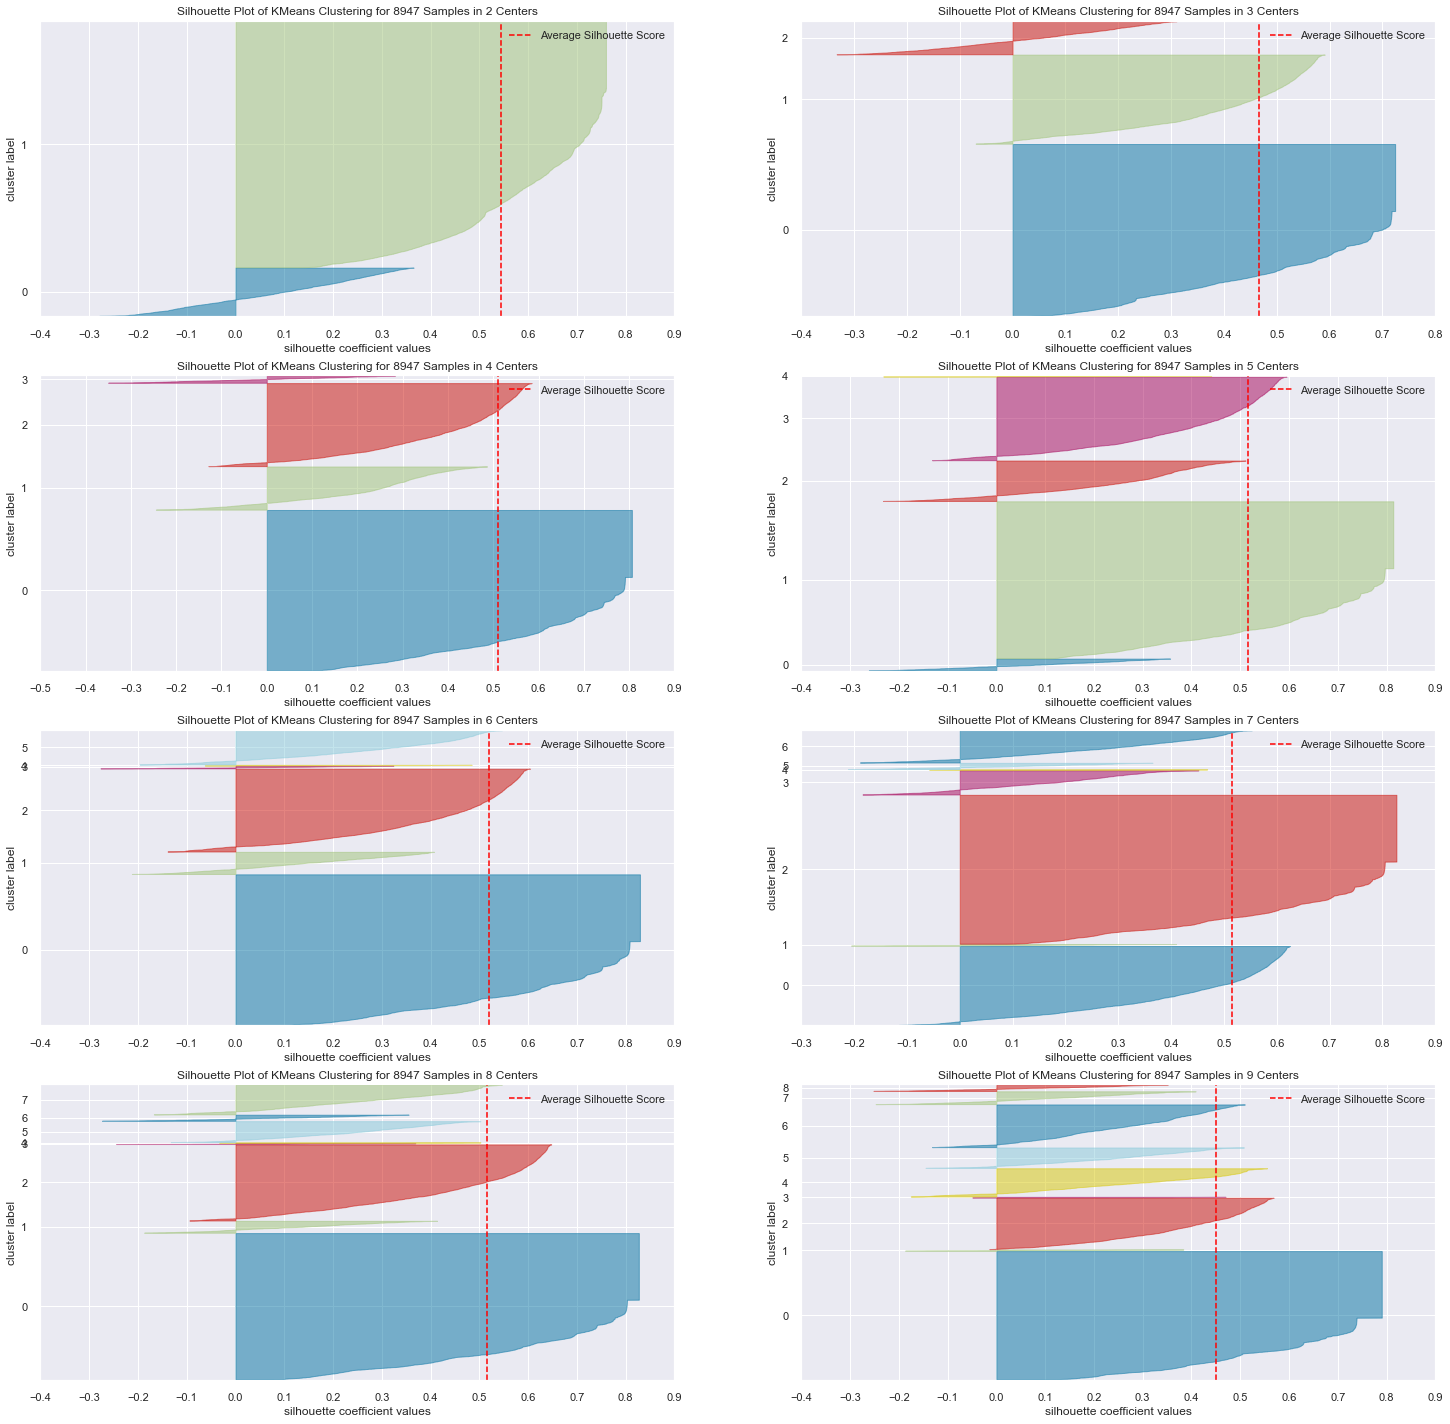

In [58]:
fig, ax = plt.subplots(4,2,figsize=(25,25))

for k in clusters:
  km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=101)
  q, mod = divmod(k,2)

  visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 7.3. Davies Bouldin Score

In [62]:
davies_list = []

for k in clusters:
  # model definition
  kmeans_model = KMeans(n_clusters=k,random_state=101)

  # model training
  kmeans_model.fit(X)

  # model predict
  labels = kmeans_model.predict(X)

  # model performance
  dav = m.davies_bouldin_score(X, labels)

  davies_list.append(dav)

Text(0, 0.5, 'Davies Boulding Score')

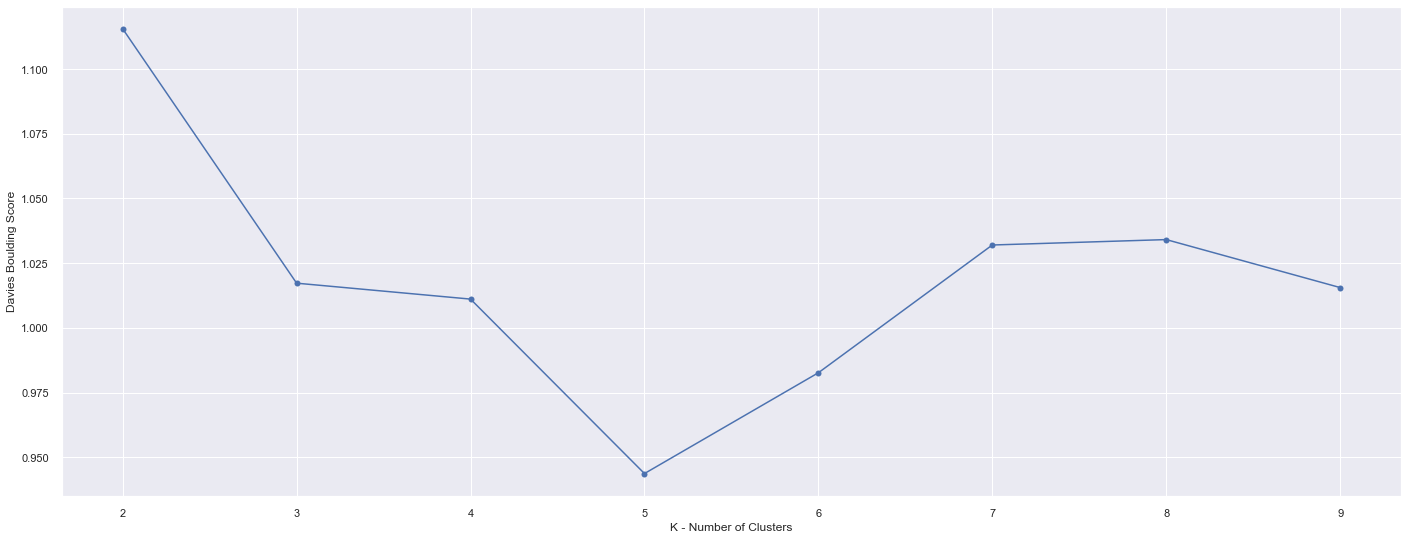

In [63]:
plt.plot(clusters, davies_list,marker='o')
plt.xlabel('K - Number of Clusters')
plt.ylabel('Davies Boulding Score')

# 8. Model Training

## 8.1. K-Means

In [65]:
# Model Definition
k = 6
kmeans = KMeans(init='random',n_clusters=k,random_state=101)

# Model Training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [66]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

# Davies Bouldin Score
print('Davies Boulding Score: {:.2f}'.format(davies_list[1]))

WWS value: 13156.15
SS value: 0.52
Davies Boulding Score: 1.02


# 9. Cluster Analysis

In [67]:
df9 = df3[['cust_id',
           'oneoff_purchases',
           'installments_purchases',
           'oneoff_purchases_frequency',
           'purchases_installments_frequency',
           'purchases_trx']].copy()
df9['cluster'] = labels
df9.head()

cust_id  oneoff_purchases  installments_purchases  oneoff_purchases_frequency  purchases_installments_frequency  purchases_trx  cluster
0    10001              0.00                    95.4                    0.000000                          0.083333              2        0
1    10002              0.00                     0.0                    0.000000                          0.000000              0        0
2    10003            773.17                     0.0                    1.000000                          0.000000             12        5
3    10004           1499.00                     0.0                    0.083333                          0.000000              1        0
4    10005             16.00                     0.0                    0.083333                          0.000000              1        0

## 9.1. Two-Dimentions Plot

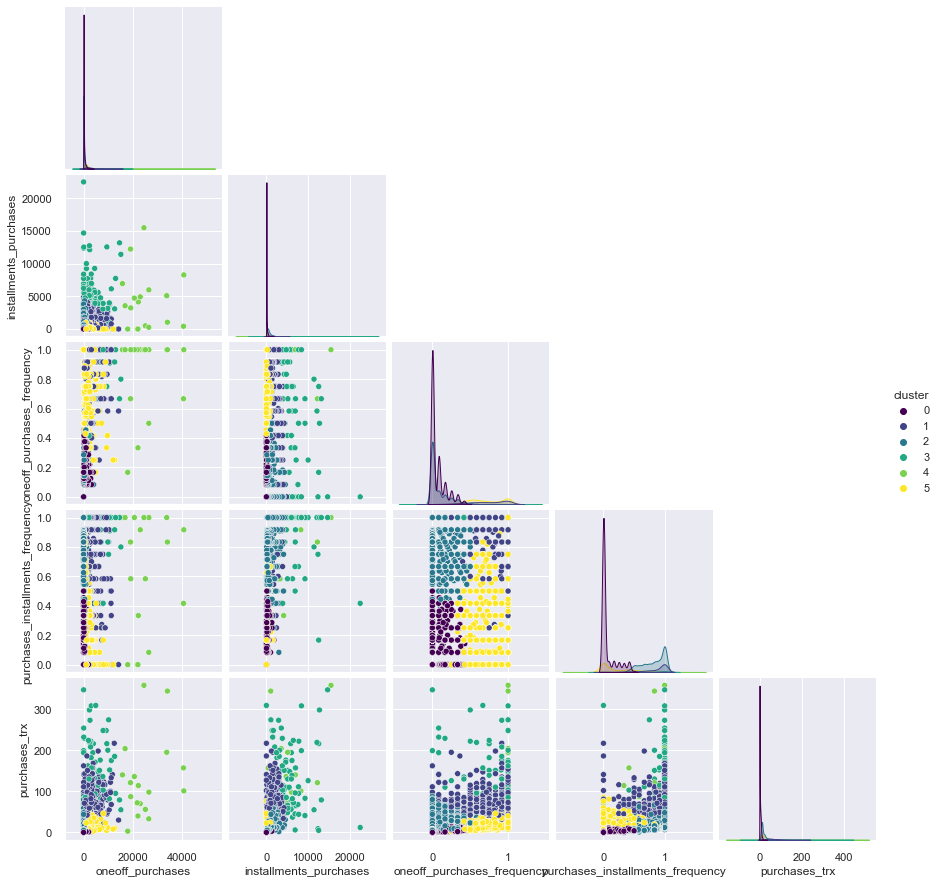

In [69]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster',palette='viridis',corner=True)

## 9.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

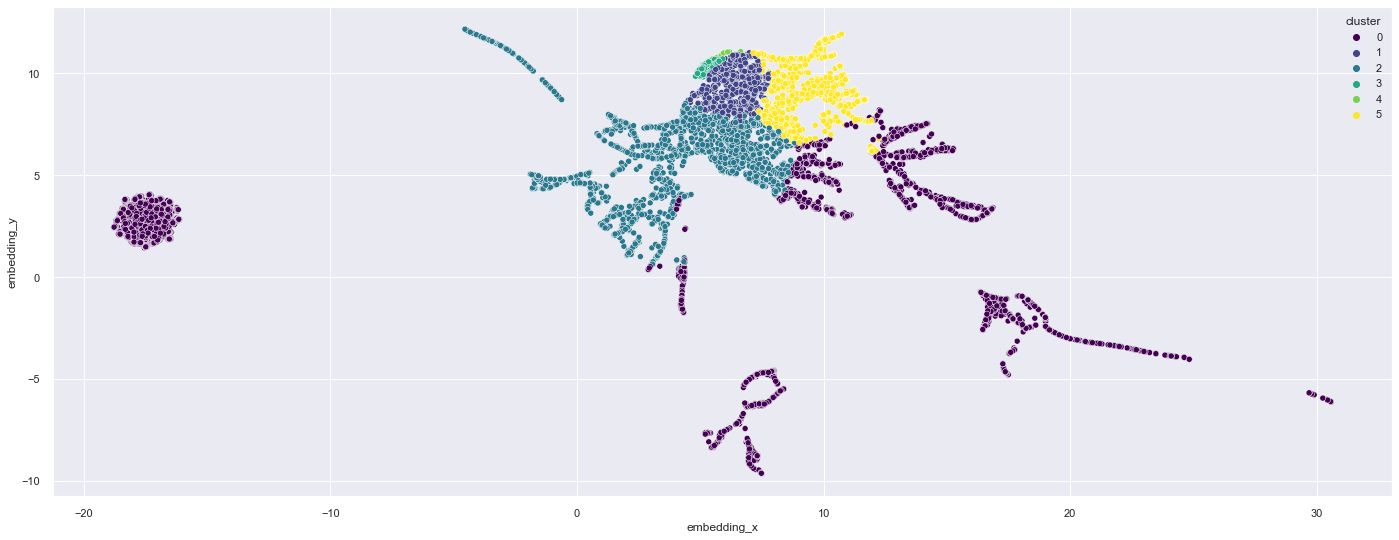

In [76]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=25,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette='viridis')

## 9.3. t-SNE

## 9.4. Cluster Profile

In [73]:
df9.columns.tolist()[1:-1]

['oneoff_purchases',
 'installments_purchases',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'purchases_trx']

In [74]:
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

for feature in df9.columns.tolist()[1:-1]:
  df_aux = df9[[feature,'cluster']].groupby('cluster').mean().reset_index()
  df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [57]:
df_cluster

NameError: name 'df_cluster' is not defined

### Cluster 01 *(High OneOff Customers)*
- Number of Customers: **18** (0.2% of customers)
- Total Paid in Cash: **$25,037**
- Total Paid in Installments: **4,270**
- Frequency of Purchases in Cash (from 0 to 1): **0.85** 
- Frequency of Purchases in Installments (from 0 to 1): **0.63** 
- Amount of Purchases: **129**

### Cluster 02 *(High Installments Customers)*
- Number of Customers: **79** (0.88% of customers)
- Total Paid in Cash: **$4,021**
- Total Paid in Installments: **6,124**
- Frequency of Purchases in Cash (from 0 to 1): **0.61** 
- Frequency of Purchases in Installments (from 0 to 1): **0.90** 
- Amount of Purchases: **136**

### Cluster 03 *(Medium Spenders)*
- Number of Customers: **676** (7.56% of customers)
- Total Paid in Cash: **$2,599**
- Total Paid in Installments: **1,434**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.87** 
- Amount of Purchases: **64**

### Cluster 04 *(Low OneOff Customers)*
- Number of Customers: **1048** (11.71% of customers)
- Total Paid in Cash: **$1,485**
- Total Paid in Installments: **172**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.20** 
- Amount of Purchases: **20**

### Cluster 05 *(Low Installments Customers)*
- Number of Customers: **2528** (28.26% of customers)
- Total Paid in Cash: **$180**
- Total Paid in Installments: **686**
- Frequency of Purchases in Cash (from 0 to 1): **0.07** 
- Frequency of Purchases in Installments (from 0 to 1): **0.81** 
- Amount of Purchases: **17**

### Cluster 06 *(Leavers)*
- Number of Customers: **4598** (51.39% of customers)
- Total Paid in Cash: **$165**
- Total Paid in Installments: **50**
- Frequency of Purchases in Cash (from 0 to 1): **0.06** 
- Frequency of Purchases in Installments (from 0 to 1): **0.06** 
- Amount of Purchases: **2**

# 10. Deploy to Production